<div style="text-align: center">
    <img src='../UDC.png' width='40%'>
    <img src='../ICI.png' width='20%'>
</div>
<div style="text-align: center">
    <p style="text-align: center">Universidad de Colima<br>
    Facultad de Ingeniería Mecánica y Eléctrica<br>
    Ingeniería en Computación Inteligente</p>
    <p style="text-align: center">Red Neuronal aplicada a imágenes de números<br>
    Aprendizaje Profundo</p>
    <p style="text-align: center">
    Larios Bravo Cristian Armando 20188165<br>
    </p>
    <p style="text-align: center">8°D</p>
</div>
<div style="text-align: right">
    Lugar: Mexico, Colima, Coquimatlan.<br>
    Fecha: 07/03/2025.
</div>

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
np.random.seed(0)

In [4]:
df = pd.read_csv("C:/Users/Cristian/Programacion/Python/AprendizajeProfundo/mnist_dataset/train.csv")

In [5]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


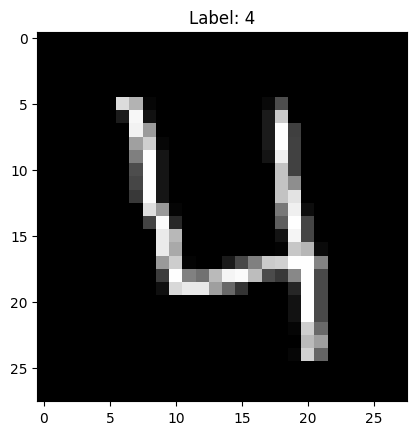

In [6]:
# Plotting the first image
plt.imshow(df.iloc[3, 1:].values.reshape(28, 28), cmap='gray')
plt.title(f'Label: {df.iloc[3, 0]}')
plt.show()

In [7]:
df_number0_1 = df[(df['label'] == 0) | (df['label'] == 1)]

In [8]:
df_number0_1['label'].value_counts()

label
1    4684
0    4132
Name: count, dtype: int64

## MLP

### Funciones de Activación

In [24]:
# 1. Sigmoide
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

# 1.1. Derivada de la función sigmoide
def sigmoide_derivada(x):
    return x * (1 - x)

# 2. ReLU
def relu(x):
    return np.maximum(0, x)

# 2.1. Derivada de la función ReLU
def relu_derivada(x):
    return np.where(x > 0, 1, 0)

# 3. Tangente Hiperbólica (tanh)
def tanh_func(x):
    return np.tanh(x)

# 3.1. Derivada de la función Tangente Hiperbólica
def tanh_derivada(x):
    return 1 - np.tanh(x)**2

# 4. Softmax
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

### Funciones de pérdida

In [25]:
#! Función de pérdida: Entropía Cruzada
def entropia_cruzada(y_real, y_pred):
    m = y_real.shape[0]
    # Añadir 1e-15 para evitar log(0)
    log_likelihood = -np.log(y_pred[range(m), y_real] + 1e-15)
    return np.sum(log_likelihood) / m

#! Función para convertir etiquetas a One-Hot Encoding
def one_hot(y, num_clases):
    one_hot_matrix = np.zeros((y.size, num_clases))
    one_hot_matrix[np.arange(y.size), y] = 1
    return one_hot_matrix

### FeedForward & BackPropagation

In [26]:
#! FeedForward + Backpropagation
def backpropagation(X, y_real, num_capas, pesos, sesgos, funciones_activacion, tasa_aprendizaje=0.01):
    #* Propagación hacia adelante
    activaciones = [X]
    z_values = []
    
    for i in range(num_capas - 1):
        z = np.dot(activaciones[-1], pesos[i]) + sesgos[i]
        z_values.append(z)
        
        if funciones_activacion[i] == "1":
            a = sigmoide(z)
        elif funciones_activacion[i] == "2":
            a = relu(z)
        elif funciones_activacion[i] == "3":
            a = tanh_func(z)
        elif funciones_activacion[i] == "4":
            a = softmax(z)
        activaciones.append(a)

    #* Retropropagación
    deltas = []
    m = X.shape[0]
    
    # Convertir y_real a One-Hot Encoding
    y_one_hot = one_hot(y_real, pesos[-1].shape[1])
    
    # Error en la capa de salida
    error_salida = activaciones[-1] - y_one_hot
    deltas.append(error_salida)
    
    # Retropropagación para capas ocultas
    for i in reversed(range(num_capas - 2)):
        if funciones_activacion[i] == "1":
            delta = np.dot(deltas[-1], pesos[i+1].T) * sigmoide_derivada(activaciones[i+1])
        elif funciones_activacion[i] == "2":
            delta = np.dot(deltas[-1], pesos[i+1].T) * relu_derivada(z_values[i])
        elif funciones_activacion[i] == "3":
            delta = np.dot(deltas[-1], pesos[i+1].T) * tanh_derivada(activaciones[i+1])
        elif funciones_activacion[i] == "4":
            # Para softmax con entropía cruzada, la derivada ya está simplificada
            delta = np.dot(deltas[-1], pesos[i+1].T)  # No multiplicar por softmax_derivada
        deltas.append(delta)
    
    deltas.reverse()
    
    # Actualización de pesos y sesgos
    for i in range(num_capas - 1):
        pesos[i] -= tasa_aprendizaje * np.dot(activaciones[i].T, deltas[i]) / m
        sesgos[i] -= tasa_aprendizaje * np.sum(deltas[i], axis=0, keepdims=True) / m
    
    return pesos, sesgos

### Cargar dataset

In [18]:
#? Cargar el dataset.
df = pd.read_csv("C:/Users/Cristian/Programacion/Python/AprendizajeProfundo/mnist_dataset/train.csv")

In [19]:
df_number0_1 = df[(df['label'] == 0) | (df['label'] == 1)]

In [21]:
X = df_number0_1.drop(['label'], axis=1).values
y = df_number0_1['label'].values

In [ ]:
# Dividir el dataset en entrenamiento, validacion y prueba (75% - 15% - 10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=0)

In [ ]:
# Después de cargar los datos:
# y = df_number1_9['label'].values
# y = np.where(y == 1, 0, 1)  # Mapeo crítico

### 1.- Definir la topologia de la red neuronal

#### 1.1. Cantidad de capas de la Red Neuronal

In [27]:
num_capas = int(input("Ingrese la cantidad de capas ocultas de la red neuronal: ")) + 2
# num_capas = 3
print(f"La red neuronal tiene {num_capas} capas.")

La red neuronal tiene 3 capas.


####       1.2. Cantidad de Neuronas en cada capa

In [28]:
num_neuronas = []
for i in range(num_capas):
    if i == 0:
        neuronas = X.shape[1]
        num_neuronas.append(neuronas)
    elif i == num_capas -1:
        neuronas = len(np.unique(y))
        num_neuronas.append(neuronas)
    else:
        neuronas = int(input(f"Ingrese la cantidad de neuronas en la capa {i+1}: "))
        num_neuronas.append(neuronas)
print(f"Cantidad de neuronas por capa: {num_neuronas}")

Cantidad de neuronas por capa: [784, 8, 2]


28x28

#### 1.3 Función de Activación en cada capa (ocultas y salida)

In [29]:
funciones_activacion = []
for i in range(num_capas -1):
    print(f"\nFUNCIONES DE ACTIVACIÓN para la capa {i+2} de {num_capas}:")
    print("1.- Sigmoide")
    print("2.- ReLU")
    print("3.- Tangente Hiperbólica")
    print("4.- Softmax (solo para la capa de salida)")
    fn = input(f"Ingrese la función de activación para la capa {i+2}: ")
    while fn not in ['1', '2', '3', '4']:
        print("Entrada inválida. Por favor, ingrese 1, 2, 3 o 4.")
        fn = input(f"Ingrese la función de activación para la capa {i+2}: ")
    funciones_activacion.append(fn)
print(f"Funciones de activación por capa: {funciones_activacion}")


FUNCIONES DE ACTIVACIÓN para la capa 2 de 3:
1.- Sigmoide
2.- ReLU
3.- Tangente Hiperbólica
4.- Softmax (solo para la capa de salida)

FUNCIONES DE ACTIVACIÓN para la capa 3 de 3:
1.- Sigmoide
2.- ReLU
3.- Tangente Hiperbólica
4.- Softmax (solo para la capa de salida)
Funciones de activación por capa: ['1', '4']


#### 2.1 Crear la matriz de pesos

In [40]:
# 1.- Inicializar los pesos y sesgos con valores aleatorios pequeños.
pesos = []
sesgos = []
for i in range(num_capas -1):
    w = np.random.uniform(-1, 1, (num_neuronas[i], num_neuronas[i+1]))
    b = np.zeros((1, num_neuronas[i+1]))
    pesos.append(w)
    sesgos.append(b)

print("Pesos y sesgos iniciales:")
print(f"{pesos}\n")
print(f"{sesgos}\n")

Pesos y sesgos iniciales:
[array([[-0.71032263,  0.521943  ,  0.82128247, ..., -0.2730049 ,
         0.69824026, -0.07545987],
       [ 0.52784425,  0.17074084,  0.95152042, ..., -0.23058882,
        -0.10181064, -0.45944078],
       [-0.4926876 ,  0.10605719,  0.34241409, ..., -0.94431344,
         0.06640063,  0.16644751],
       ...,
       [ 0.01903196,  0.8190039 , -0.49897537, ..., -0.26608073,
        -0.70765447, -0.26880991],
       [-0.44215234,  0.16384266, -0.49607789, ...,  0.34993855,
        -0.5867588 , -0.24818464],
       [-0.12355999,  0.62211853,  0.77760296, ...,  0.62688617,
         0.29933169,  0.71476762]]), array([[-0.64937066,  0.97464615],
       [-0.73273443,  0.29299976],
       [-0.97086931,  0.8234687 ],
       [-0.52499608,  0.65477292],
       [ 0.6116171 , -0.21568153],
       [ 0.16947703, -0.28117372],
       [ 0.6171512 , -0.36131427],
       [ 0.31865252,  0.17806208]])]

[array([[0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0.]])]



### Épocas y tasa de aprendizaje

In [41]:
while True:
    epocas = str(input("Ingrese la cantidad de épocas: "))
    tasa_aprendizaje = str(input("Ingrese la tasa de aprendizaje: "))
    
    # Validar que sean números
    if epocas.isnumeric() and tasa_aprendizaje.replace(".", "", 1).isdigit():
        epocas = int(epocas)
        tasa_aprendizaje = float(tasa_aprendizaje)
        break
    else:
        print("Entrada inválida. Por favor, ingrese un número entero para las épocas y un número decimal para la tasa de aprendizaje.")

### Entrenamiento

In [42]:
# Entrenamiento utilizando X_train y y_train, evaluando cada 100 épocas en el conjunto de validación
for epoca in range(epocas):
    # Entrenamiento sample por sample (puedes vectorizar si lo prefieres)
    for i in range(X_train.shape[0]):
        X_sample = X_train[i].reshape(1, -1)
        y_sample = y_train[i]
        pesos, sesgos = backpropagation(X_sample, y_sample, num_capas, pesos, sesgos, funciones_activacion, tasa_aprendizaje)
    
    # Cada 100 épocas, calculamos la pérdida y exactitud tanto en entrenamiento como en validación
    if (epoca+1) % 10 == 0:
        # Evaluación en el conjunto de entrenamiento
        activaciones_train = [X_train]
        for j in range(num_capas - 1):
            z = np.dot(activaciones_train[-1], pesos[j]) + sesgos[j]
            if funciones_activacion[j] == "1":
                a = sigmoide(z)
            elif funciones_activacion[j] == "2":
                a = relu(z)
            elif funciones_activacion[j] == "3":
                a = tanh_func(z)
            elif funciones_activacion[j] == "4":
                a = softmax(z)
            activaciones_train.append(a)
        loss_train = entropia_cruzada(y_train, activaciones_train[-1])
        y_pred_train = np.argmax(activaciones_train[-1], axis=1)
        accuracy_train = np.mean(y_pred_train == y_train)

        # Evaluación en el conjunto de validación
        activaciones_val = [X_val]
        for j in range(num_capas - 1):
            z = np.dot(activaciones_val[-1], pesos[j]) + sesgos[j]
            if funciones_activacion[j] == "1":
                a = sigmoide(z)
            elif funciones_activacion[j] == "2":
                a = relu(z)
            elif funciones_activacion[j] == "3":
                a = tanh_func(z)
            elif funciones_activacion[j] == "4":
                a = softmax(z)
            activaciones_val.append(a)
        loss_val = entropia_cruzada(y_val, activaciones_val[-1])
        y_pred_val = np.argmax(activaciones_val[-1], axis=1)
        accuracy_val = np.mean(y_pred_val == y_val)
        
        print(f"Época {epoca+1}")
        print(f"  Pérdida entrenamiento: {loss_train:.4f} - Exactitud entrenamiento: {accuracy_train * 100:.2f}%")
        print(f"  Pérdida validación:  {loss_val:.4f} - Exactitud validación:  {accuracy_val * 100:.2f}%")


C:\Users\Cristian\AppData\Local\Temp\ipykernel_30940\2904487109.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Época 10
  Pérdida entrenamiento: 0.2570 - Exactitud entrenamiento: 95.60%
  Pérdida validación:  0.2504 - Exactitud validación:  96.44%
Época 20
  Pérdida entrenamiento: 0.1379 - Exactitud entrenamiento: 98.22%
  Pérdida validación:  0.1389 - Exactitud validación:  97.96%
Época 30
  Pérdida entrenamiento: 0.0931 - Exactitud entrenamiento: 98.61%
  Pérdida validación:  0.0998 - Exactitud validación:  98.34%
Época 40
  Pérdida entrenamiento: 0.0722 - Exactitud entrenamiento: 98.73%
  Pérdida validación:  0.0793 - Exactitud validación:  98.49%
Época 50
  Pérdida entrenamiento: 0.0610 - Exactitud entrenamiento: 98.85%
  Pérdida validación:  0.0693 - Exactitud validación:  98.56%
Época 60
  Pérdida entrenamiento: 0.0520 - Exactitud entrenamiento: 98.97%
  Pérdida validación:  0.0589 - Exactitud validación:  98.79%
Época 70
  Pérdida entrenamiento: 0.0465 - Exactitud entrenamiento: 99.00%
  Pérdida validación:  0.0536 - Exactitud validación:  98.79%
Época 80
  Pérdida entrenamiento: 0.0427 

### Prueba de la red neuronal

In [43]:
y_pred_prueba = []
for i in range(X_test.shape[0]):
    a = X_test[i].reshape(1, -1)
    for j in range(num_capas -1):
        z = np.dot(a, pesos[j]) + sesgos[j]
        if funciones_activacion[j] == "1":
            a = sigmoide(z)
        elif funciones_activacion[j] == "2":
            a = relu(z)
        elif funciones_activacion[j] == "3":
            a = tanh_func(z)
        elif funciones_activacion[j] == "4":
            a = softmax(z)
    predicción = np.argmax(a, axis=1)[0]
    y_pred_prueba.append(predicción)
    print(f"Predicción: {predicción} - Real: {y_test[i]}")

Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 1 - Real: 1
Predicción: 0 - Real: 0
Predicción: 0 - 

C:\Users\Cristian\AppData\Local\Temp\ipykernel_30940\2904487109.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


### Calcular exactitud

In [44]:
exactitud = np.mean(np.array(y_pred_prueba) == y_test)
print(f"Exactitud en el conjunto de prueba: {exactitud * 100:.2f}%")

Exactitud en el conjunto de prueba: 98.53%


### Pesos y sesgos finales

In [45]:
print("PESOS Y SESGOS FINALES")
print(f"{pesos}\n")
print(f"{sesgos}\n")

PESOS Y SESGOS FINALES
[array([[-0.71032263,  0.521943  ,  0.82128247, ..., -0.2730049 ,
         0.69824026, -0.07545987],
       [ 0.52784425,  0.17074084,  0.95152042, ..., -0.23058882,
        -0.10181064, -0.45944078],
       [-0.4926876 ,  0.10605719,  0.34241409, ..., -0.94431344,
         0.06640063,  0.16644751],
       ...,
       [ 0.01903196,  0.8190039 , -0.49897537, ..., -0.26608073,
        -0.70765447, -0.26880991],
       [-0.44215234,  0.16384266, -0.49607789, ...,  0.34993855,
        -0.5867588 , -0.24818464],
       [-0.12355999,  0.62211853,  0.77760296, ...,  0.62688617,
         0.29933169,  0.71476762]]), array([[-2.1122663 ,  2.43754179],
       [-0.80706759,  0.36733292],
       [-0.80422139,  0.65682078],
       [ 0.19931597, -0.06953913],
       [ 1.44450552, -1.04856996],
       [ 0.72804654, -0.83974323],
       [ 0.05470957,  0.20112736],
       [-0.19749994,  0.69421454]])]

[array([[ 0.00049342, -0.00024586, -0.00015671,  0.00025146, -0.00031629,
     

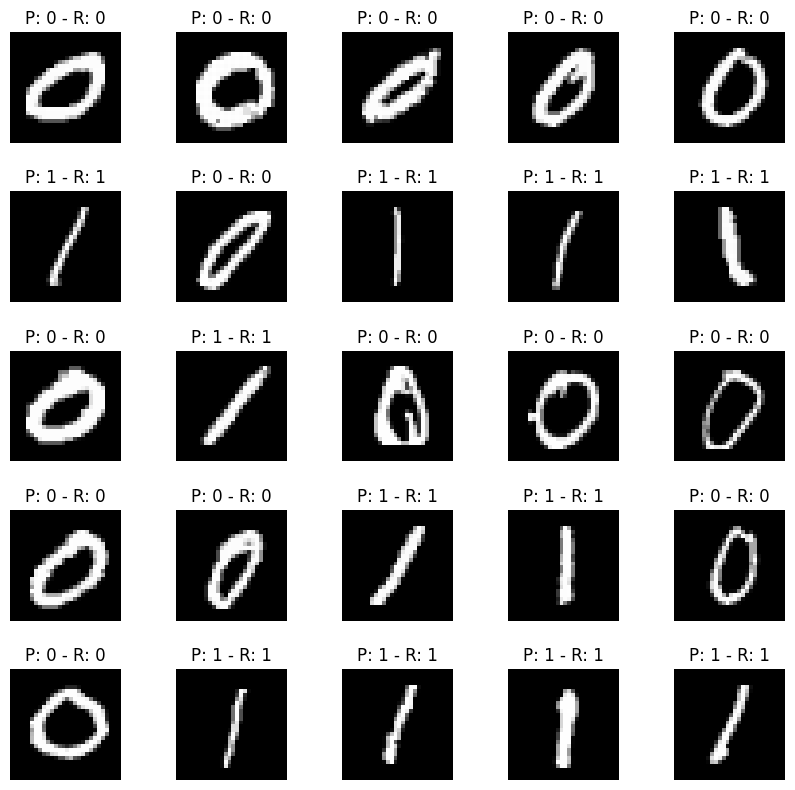

In [53]:
# Plotear imagenes con sus predicciones
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"P: {y_pred_prueba[i]} - R: {y_test[i]}")
    plt.axis('off')
    # Añadir espacio entre las imágenes
    plt.subplots_adjust(wspace=0.5)
plt.show()